In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

##### Step 1. Data Preprocessing

In [2]:
# ===========================
# Load Data 
# ===========================
ticker = 'LULU'
start_date = '2021-01-01'
end_date = '2024-12-31'
market_data = (
    yf.download(ticker, start=start_date, end=end_date, 
                auto_adjust=True, progress=False)
    .pipe(lambda df: df.set_axis([col[0] for col in df.columns], axis=1))
    .join(
        yf.download(['^GSPC', '^VIX', 'GC=F', 'CL=F'], start=start_date, end=end_date, 
                    auto_adjust=True, progress=False)['Close']
        .rename(columns={'^GSPC': 'Benchmark', '^VIX': 'VIX', 'GC=F': 'Gold', 'CL=F': 'Crude_Oil'})
    )
    .dropna(how='all')
)

# Fama French
fama_french_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',  start=start_date, end=end_date)[0]
fama_french_data.index = fama_french_data.index.to_timestamp() + pd.offsets.MonthEnd(0)
for col in fama_french_data.columns:
    if col == 'RF': 
        fama_french_data[col] = fama_french_data[col]/10
    else:
        fama_french_data[col] = fama_french_data[col]/100

# Combined dataframe        
market_data = market_data.merge(fama_french_data, left_index=True, right_index=True, how='left')
market_data = market_data.ffill().dropna()

# ===========================
# Feature Engineering
# ===========================
class FeatureEngineer:
    def __init__(self, lookback_window=90):
        self.lookback = lookback_window
        
    def add_features(self, df):
        df = self._add_price_features(df)
        df = self._add_technical_indicators(df)
        df = self._add_benchmark_features(df)
        df = self._add_market_features(df)
        df = self._add_seasonal_features(df)
        return df.dropna()
    
    def _add_price_features(self, df):       
        df['Daily_Return'] = df['Close'].pct_change()
        df['Intraday_Change'] = df['Close'] / df['Open'] - 1
        df['Overnight_Gap '] = df['Open'] - df['Close'].shift(1)
        df['EMA5'] = df['Close'].ewm(span=5, adjust=True).mean()
        df['EMA10'] = df['Close'].ewm(span=10, adjust=True).mean()
        df['EMA20'] = df['Close'].ewm(span=20,adjust=True).mean()
        df['EMA50'] = df['Close'].ewm(span=50, adjust=True).mean()
        df['EMA20/50_Ratio'] = df['EMA20'] / df['EMA50']
        df['Price_EMA_Ratio'] = df['Close'] / df['EMA20']
        return df
    
    def _add_technical_indicators(self, df):
        df['RSI14'] = self._calculate_rsi(df['Close'])
        df['MACD'] = self._calculate_macd(df['Close'])
        df['Upper_Band'] = df['EMA20'] + 1.5*df['Close'].rolling(20).std()
        df['Lower_Band'] = df['EMA20'] - 1.5*df['Close'].rolling(20).std()
        df['Bollinger_Band'] = (df['Close'] - df['Lower_Band'])/(df['Upper_Band'] - df['Lower_Band'])
        df['Volatility_21d'] = df['Daily_Return'].rolling(21).std() * np.sqrt(252) 
        df['Volatility_5d'] = df['Daily_Return'].rolling(5).std() * np.sqrt(252)
        df['Volatility_Ratio'] = df['Volatility_5d'] / df['Volatility_21d']
        return df

    def _add_benchmark_features(self, df):
        df['Daily_Return_Bench'] = df['Benchmark'].pct_change()
        df['Beta'] = self._calculate_beta(df['Close'], df['Benchmark'], df['RF'])
        df['Excess_Return'] = df['Daily_Return']-df['Daily_Return_Bench']
        df['Relative_Strength'] = df['Close'] / df['Benchmark']
        return df
    
    def _add_market_features(self, df):
        df['VIX_Change'] = df['VIX'].pct_change()
        df['Gold_Return'] = df['Gold'].pct_change()
        #df['Crude_Oil_Return'] = df['Crude_Oil'].pct_change()
        df['Gold_Correlation'] = df['Close'].rolling(21).corr(df['Gold'])
        return df
    
    def _add_seasonal_features(self, df):
        dates = df.index
        year_progress = dates.dayofyear / 365
        current_year = dates.year[0] 
        holiday_dates = [f'{current_year}-12-24', f'{current_year}-12-31', f'{current_year}-07-03', f'{current_year}-11-27']
        df['Year_sin'] = np.sin(2 * np.pi * year_progress)
        df['Year_cos'] = np.cos(2 * np.pi * year_progress)
        df['Month_sin'] = np.sin(2 * np.pi * dates.month/12)
        df['Month_cos'] = np.cos(2 * np.pi * dates.month/12)
        df['Week_sin'] = np.sin(2 * np.pi * dates.isocalendar().week/52)
        df['Week_cos'] = np.cos(2 * np.pi * dates.isocalendar().week/52)
        df['Month_end'] = dates.is_month_end.astype(int)
        df['Quarter_end'] = dates.is_quarter_end.astype(int)
        df['Year_end'] = dates.is_year_end.astype(int)
        df['Monday_effect'] = (dates.dayofweek == 0).astype(int)
        df['Friday_effect'] = (dates.dayofweek == 4).astype(int)
        df['First_day_month'] = (dates.day == 1).astype(int)
        df['Monthly_seasonality'] = df['Close'].pct_change().rolling(21).mean()
        df['Quarterly_seasonality'] = df['Close'].pct_change().rolling(63).mean()
        df['Annual_seasonality'] = df['Close'].pct_change().rolling(252).mean()
        df['Pre_holiday'] = dates.normalize().isin(
            pd.to_datetime(holiday_dates)
        ).astype(int)
        return df
    
    def _calculate_rsi(self, series, window=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
        avg_loss = loss.ewm(com=window-1, min_periods=window).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))

    def _calculate_macd(self, series, fast=12, slow=26, signal=9):
        ema_fast = series.ewm(span=fast, adjust=False).mean()
        ema_slow = series.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        return macd

    def _calculate_beta(self, stock, bench, risk_free):
        excess_stock = stock.pct_change() - risk_free / 252
        excess_bench = bench.pct_change() - risk_free / 252
        covariance = excess_stock.rolling(self.lookback).cov(excess_bench)
        variance = excess_bench.rolling(self.lookback).var()
        return covariance / variance
    

# ===========================
# Stationarity Check 
# ===========================
def check_stationarity(df):
    """Check and drop non-stationary series."""
    stationary_df = df.copy()
    dropped_cols = []

    for col in df.columns:
        p_val = adfuller(df[col].dropna())[1]
        if p_val >= 0.05: #non-stationary
            dropped_cols.append(col)
    stationary_df = stationary_df.drop(columns=dropped_cols)
    
    return stationary_df, dropped_cols

# ===========================
# Excecution 
# ===========================
# Apply feature engineering
engineer = FeatureEngineer()
processed_data = engineer.add_features(market_data)
stationary_df, dropped_cols = check_stationarity(processed_data)
print(f'Dropped factors:{dropped_cols}')
print(f'Remaining factors:{stationary_df.columns}')

Dropped factors:['Close', 'High', 'Low', 'Open', 'Crude_Oil', 'Gold', 'Benchmark', 'VIX', 'RF', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'Upper_Band', 'Lower_Band', 'Beta', 'Relative_Strength', 'Month_sin', 'Month_cos', 'Quarterly_seasonality', 'Annual_seasonality']
Remaining factors:Index(['Volume', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Daily_Return',
       'Intraday_Change', 'Overnight_Gap ', 'EMA20/50_Ratio',
       'Price_EMA_Ratio', 'RSI14', 'MACD', 'Bollinger_Band', 'Volatility_21d',
       'Volatility_5d', 'Volatility_Ratio', 'Daily_Return_Bench',
       'Excess_Return', 'VIX_Change', 'Gold_Return', 'Gold_Correlation',
       'Year_sin', 'Year_cos', 'Week_sin', 'Week_cos', 'Month_end',
       'Quarter_end', 'Year_end', 'Monday_effect', 'Friday_effect',
       'First_day_month', 'Monthly_seasonality', 'Pre_holiday'],
      dtype='object')


In [3]:
# ===========================
# Set Parameters
# ===========================
WINDOW_SIZE = 10
LOOK_AHEAD = 1
TRAIN_RATIO = 0.8
VAL_RATIO = 0.9  # Of the training set

# ===========================
# Split and Scale Data
# ===========================
def time_series_train_test_split(df, train_ratio, val_ratio):
    train_size = int(len(df) * train_ratio)
    val_size = int(train_size * val_ratio)
    
    train = df.iloc[:val_size]
    val = df.iloc[val_size:train_size]
    test = df.iloc[train_size:]
    
    return train, val, test

def create_sequences(data, features, target, window_size, look_ahead):
    X, y, y_dates = [], [], []
    for i in range(len(data) - window_size - look_ahead + 1):
        X.append(data[features].iloc[i:i+window_size].values)
        target_idx = i + window_size + look_ahead - 1
        y.append(data[target].iloc[target_idx])
        y_dates.append(data.index[target_idx])
    
    X_array = np.array(X)
    y_df = pd.DataFrame(y, index=pd.to_datetime(y_dates), columns=[target])
    return X_array, y_df[target].values.ravel()

# ===========================
# Main Pipeline
# ===========================
# Split data
train, val, test = time_series_train_test_split(stationary_df, TRAIN_RATIO, VAL_RATIO)
price = market_data.loc[stationary_df.index]['Close']

# Define features and target
features = stationary_df.columns.drop('Daily_Return')
target = 'Daily_Return'

# For non-sequence models
offset = WINDOW_SIZE + LOOK_AHEAD - 1
X_train, y_train = train[features].iloc[offset-1:-1], train[target].iloc[offset:]
X_val, y_val = val[features].iloc[offset-1:-1], val[target].iloc[offset:]
X_test, y_test = test[features].iloc[offset-1:-1], test[target].iloc[offset:]

# Scale features before windowing
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train[features])
val_features_scaled = scaler.transform(val[features])
test_features_scaled = scaler.transform(test[features])

# Create DataFrames with scaled features
train_scaled = train.copy()
train_scaled[features] = train_features_scaled
val_scaled = val.copy()
val_scaled[features] = val_features_scaled
test_scaled = test.copy()
test_scaled[features] = test_features_scaled

# Create sequences from scaled data
X_train_seq, y_train_seq = create_sequences(train_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)
X_val_seq, y_val_seq = create_sequences(val_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)
X_test_seq, y_test_seq = create_sequences(test_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)

# Prepare price for evaluation
def get_price_pairs(price, target_index):
    idx = price.index.get_indexer(target_index)
    valid = idx > 0  # exclude -1 from get_indexer (invalid match)
    current_indices = price.index[idx[valid]]
    previous_indices = price.index[idx[valid] - 1]

    return pd.DataFrame({
        'Price': price.loc[current_indices].values,
        'Prev_Price': price.loc[previous_indices].values
    }, index=current_indices)

price_val_df = get_price_pairs(price, y_val.index)
price_test_df = get_price_pairs(price, y_test.index)

# ===========================
# Verify Output
# ===========================
print(f"Train non-sequences: {X_train.shape}")
print(f"Validation non-sequences: {X_val.shape}")
print(f"Test non-sequences: {X_test.shape}")
print(f"Train sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Validation price: {len(price_val_df)}")
print(f"Validation return: {len(y_val)}")
print(f"Test price: {len(price_test_df)}")
print(f"Test return: {len(y_test)}")

Train non-sequences: (487, 33)
Validation non-sequences: (46, 33)
Test non-sequences: (129, 33)
Train sequences: (487, 10, 33)
Validation sequences: (46, 10, 33)
Test sequences: (129, 10, 33)
Validation price: 46
Validation return: 46
Test price: 129
Test return: 129


##### Step 2. Modeling

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
Best model by RMSE: rnn
             MAE       RMSE      MAPE
ridge   6.685759   8.631175  0.020089
rf      6.290908   8.253757  0.018978
rnn     5.886106   7.954614  0.017789
lstm   25.206615  26.918255  0.074535


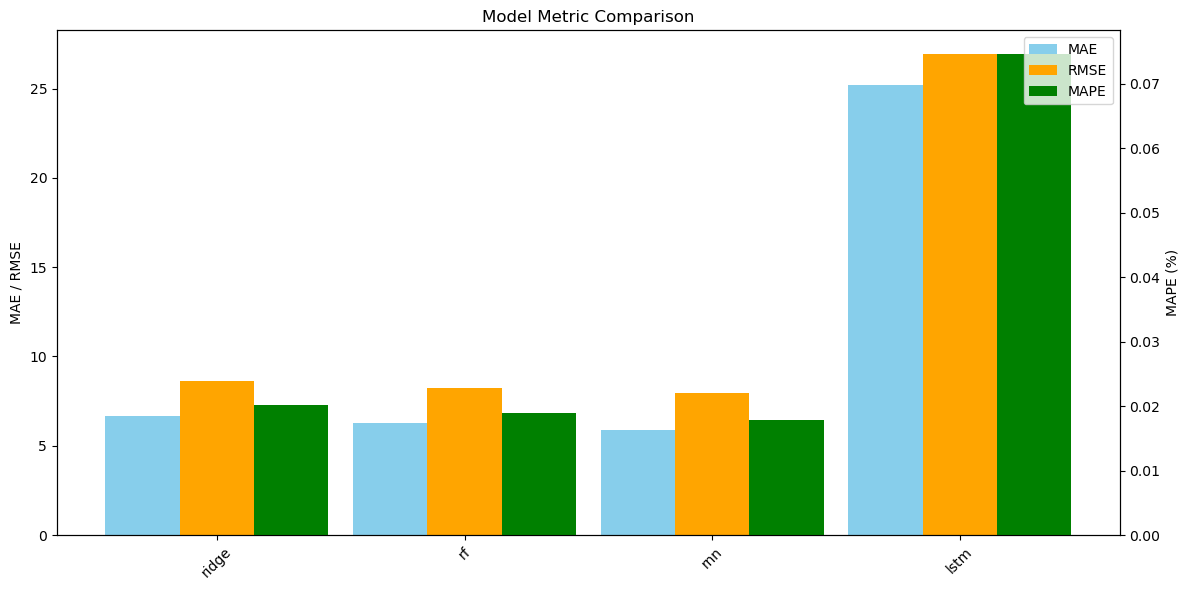

In [4]:
# ===========================
# Non-Sequence Models
# ===========================
def build_non_sequence_models():
    models = {
        'ridge': Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge(alpha=1.0))
        ]),
        'rf': RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
    }
    return models


# ===========================
# Sequence Models
# ===========================
def build_sequence_models(input_shape, dropout_rate=0.2):
    models = {}
    model_defs = {
        'rnn': [
            Input(shape=input_shape),
            BatchNormalization(),
            SimpleRNN(128, return_sequences=False),
            Dropout(dropout_rate),
            Dense(64, activation='relu'),
            Dropout(dropout_rate),
            Dense(1)  # Linear output for regression
        ],
        'lstm': [
            Input(shape=input_shape),
            BatchNormalization(),
            LSTM(128, return_sequences=True),
            Dropout(dropout_rate),
            LSTM(64, return_sequences=False),
            Dropout(dropout_rate),
            Dense(32, activation='relu'),
            Dense(1)  # Linear output for regression
        ]
    }

    for name, layers in model_defs.items():
        model = Sequential(layers)
        model.compile(
            optimizer=Adam(learning_rate=0.005),
            loss='mse'
        )
        models[name] = model

    return models


# ===========================
# Evaluation and Comparison
# ===========================
def evaluate_model(model, true_price, pred_price):
    mae = mean_absolute_error(true_price, pred_price)
    rmse = mean_squared_error(true_price, pred_price, squared=False)
    mape = mean_absolute_percentage_error(true_price, pred_price)

    return {
        'model': model,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }


def plot_all_model_metrics(metrics_df):
    metrics = ["MAE", "RMSE", "MAPE"]
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    width = 0.3
    x = np.arange(len(metrics_df.index))

    ax1.bar(x - width, metrics_df["MAE"], width, label='MAE', color='skyblue')
    ax1.bar(x, metrics_df["RMSE"], width, label='RMSE', color='orange')
    ax2.bar(x + width, metrics_df["MAPE"], width, label='MAPE', color='green')

    ax1.set_ylabel("MAE / RMSE")
    ax2.set_ylabel("MAPE (%)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_df.index, rotation=45)
    ax1.set_title("Model Metric Comparison")
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

# ===========================
# Execution
# ===========================
if __name__ == "__main__":
    non_seq_models = build_non_sequence_models()
    non_seq_results = {}
    pred_df = pd.DataFrame(index=price_val_df.index)  # New dataframe to store all predictions
    pred_df['Actual'] = price_val_df['Price']

    for name, model in non_seq_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val).flatten()
        pred_price = price_val_df['Prev_Price'] * (1 + y_pred)
        true_price = price_val_df['Price']
        pred_df[f'Pred_{name}'] = pred_price
        non_seq_results[name] = evaluate_model(model, true_price, pred_price)

    seq_models = build_sequence_models(X_train_seq.shape[1:])
    seq_results = {}

    for name, model in seq_models.items():
        model.fit(X_train_seq, y_train, epochs=100, batch_size=64, shuffle=False, verbose=0)
        y_pred = model.predict(X_val_seq).flatten()
        pred_price = price_val_df['Prev_Price'].values * (1 + y_pred)
        true_price = price_val_df['Price']
        pred_df[f'Pred_{name}'] = pred_price
        seq_results[name] = evaluate_model(model, true_price, pred_price)
    
    all_results = {**non_seq_results, **seq_results}
    metrics_df = pd.DataFrame(all_results).T
    best_model_name = metrics_df['RMSE'].idxmin()
    best_model = all_results[best_model_name]['model']
    print(f"Best model by RMSE: {best_model_name}")
    print(metrics_df.drop(['model'],axis=1))
    plot_all_model_metrics(metrics_df)

##### Step 3. Backtesting

In [5]:
# ============================
# Apply Best Model on Test Set
# ============================
if best_model_name in ['rnn', 'lstm']:
    y_pred = best_model.predict(X_test_seq).flatten()
else:
    y_pred = best_model.predict(X_test).flatten()

# Calculate predicted and true price
pred_price = price_test_df['Prev_Price'] * (1 + y_pred)
true_price = price_test_df['Price']

# ============================
# Prepare Trading Data
# ============================
# Merge previous-day technical indicators
prev_tech_indicators = market_data[['Upper_Band', 'Lower_Band', 'EMA5','EMA10', 'EMA20', 'EMA50']].shift(1)

trade_price = price_test_df.copy()
trade_price['Pred_Price'] = pred_price

# Merge with current day's close/open/RF and previous day's indicators
trade_price = trade_price.merge(
    market_data[['Close', 'Open', 'RF']],
    left_index=True, right_index=True
).merge(
    prev_tech_indicators,
    left_index=True, right_index=True,
    suffixes=('', '_Prev')
)

# ============================ 
# Generate Trading Signals 
# ============================ 
def generate_strategy_signals(trade_price):
    """Generate trading signals based on predicted returns, Bollinger Bands, and EMAs."""
    
    # Initialize strategy signal columns
    trade_price['Signal_Benchmark'] = 0
    trade_price['Signal_D-1_Price'] = 0
    trade_price['Signal_D-2_Price'] = 0
    trade_price['Signal_EMA5'] = 0
    trade_price['Signal_EMA10'] = 0

    # Strategy 0: Benchmark - Buy if previous actual return > 0
    trade_price.loc[trade_price['Prev_Price'] > trade_price['Prev_Price'].shift(1), 'Signal_Benchmark'] = 1

    # Strategy 1: Buy if predicted price > previous close
    trade_price.loc[trade_price['Pred_Price'] > trade_price['Prev_Price'], 'Signal_D-1_Price'] = 1

    # Strategy 2: Buy if predicted price > close two days ago
    trade_price.loc[trade_price['Pred_Price'] > trade_price['Prev_Price'].shift(1), 'Signal_D-2_Price'] = 1

    # Strategy 3: EMA5 - momentum logic
    trade_price.loc[trade_price['Pred_Price'] > trade_price['EMA5'], 'Signal_EMA5'] = 1

    # Strategy 4: EMA10 - momentum logic
    trade_price.loc[trade_price['Pred_Price'] > trade_price['EMA10'], 'Signal_EMA10'] = 1

    return trade_price

# ============================  
# Trading Strategies
# ============================  

def compare_strategies(trade_price, signal_cols, initial_balance=10000, transaction_cost=0.001):
    """
    Intraday backtest assuming all-in trades per signal:
    - Signal 1: Buy at open, sell at close with all cash
    - Signal -1: Short at open, cover at close with all cash
    - No partial position sizing (100% capital used per trade)
    """

    portfolio_values_with_diff_strategies = {}
    trade_counts = {}

    for col in signal_cols:
        cash = initial_balance
        portfolio_values = []
        n_trade = 0

        for i, row in trade_price.iterrows():
            signal = row[col]
            open_price = row['Open']
            close_price = row['Close']

            if signal == 1:
                # Buy at open, sell at close using all cash
                cost_per_share = open_price * (1 + transaction_cost)
                shares = int(cash // cost_per_share)

                if shares > 0:
                    cost = shares * cost_per_share
                    cash -= cost
                    proceeds = shares * close_price * (1 - transaction_cost)
                    cash += proceeds
                    n_trade += 1

            portfolio_values.append(cash)

        portfolio_values_with_diff_strategies[col] = pd.Series(portfolio_values, index=trade_price.index)
        trade_counts[col] = n_trade

    return pd.DataFrame(portfolio_values_with_diff_strategies), trade_counts


# ===========================================
# Performance Analysis
# ===========================================

def backtest_results(trade_price, portfolio_results, strategies, initial_balance=10000, risk_free_rate=0.03):

    # ===========================================
    # 1. Visualization of Trading Signals (per strategy)
    # ===========================================
    for strategy in strategies:
        plt.figure(figsize=(12, 4))
        plt.plot(trade_price['Prev_Price'], label='Actual Price', color='blue', alpha=0.7)

        if 'Pred_Price' in trade_price.columns:
            plt.plot(trade_price['Pred_Price'], label='Predicted Price', color='orange', alpha=0.7)

        buy_signals = trade_price[trade_price[strategy] == 1]

        plt.scatter(buy_signals.index, buy_signals['Prev_Price'],
                    marker='^', color='green', label='Buy Signal', alpha=0.6)
        plt.title(f'Trading Signals: {strategy}')
        plt.ylabel('Price')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ===========================================
    # 2. Portfolio Performance Comparison
    # ===========================================
    plt.figure(figsize=(14, 6))
    for strategy, values in portfolio_results.items():
        plt.plot(values, label=strategy)
    
    plt.title('Portfolio Value Comparison')
    plt.ylabel('Portfolio Value ($)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===========================================
    # 3. Performance Metrics Calculation
    # ===========================================
    performance_metrics = {}

    for strategy, portfolio_series in portfolio_results.items():
        returns = portfolio_series.pct_change().dropna()
        num_trades = trade_counts[strategy]
        cumulative_return = (portfolio_series.iloc[-1] / initial_balance) - 1
        annualized_return = (1 + cumulative_return) ** (252 / len(portfolio_series)) - 1
        volatility = returns.std() * np.sqrt(252)
        max_drawdown = ((portfolio_series.cummax() - portfolio_series) / portfolio_series.cummax()).max()
        sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility else np.nan

        signals = trade_price[strategy]
        win_signals = trade_price[signals == 1]
        win_returns = (win_signals['Close'] - win_signals['Open']) / win_signals['Open']
        win_rate = (win_returns > 0).mean() if not win_returns.empty else np.nan

        performance_metrics[strategy] = {
            'Final Value': portfolio_series.iloc[-1],
            'Cumulative Return': cumulative_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Num Trades': num_trades,
            "Win Rate": win_rate
        }

    metrics_df = pd.DataFrame.from_dict(performance_metrics, orient='index')

    return metrics_df


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


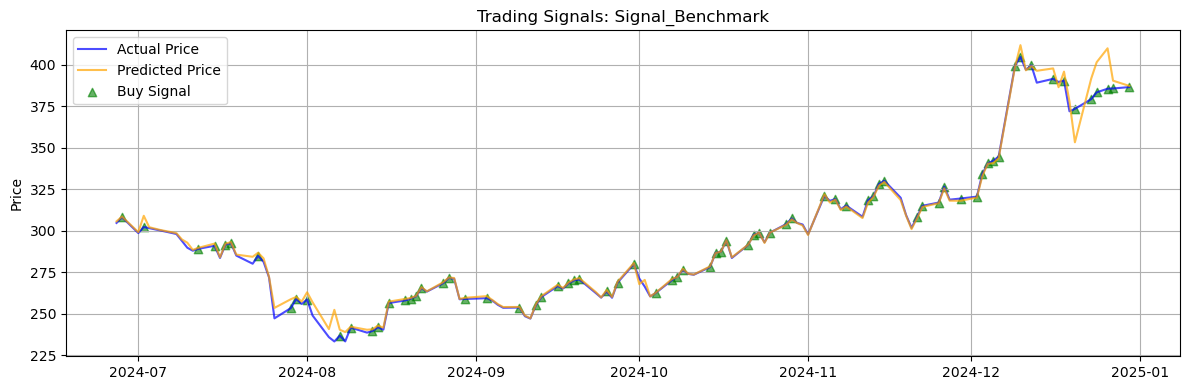

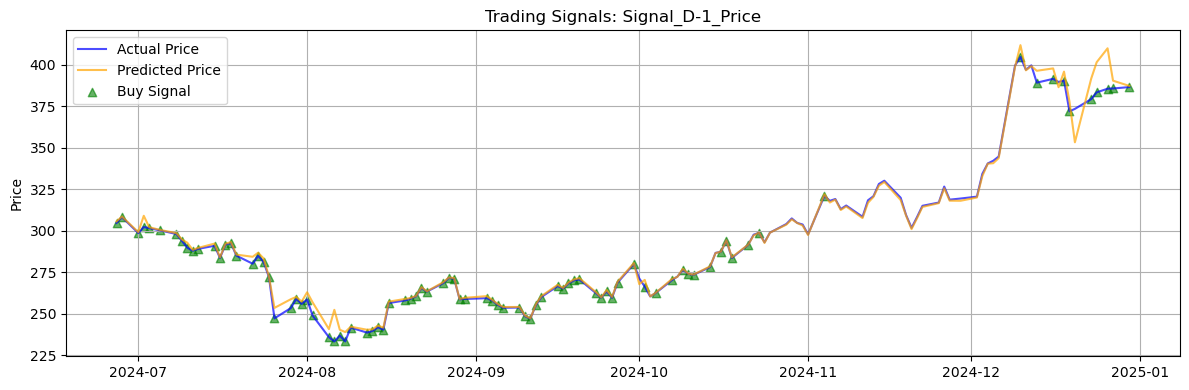

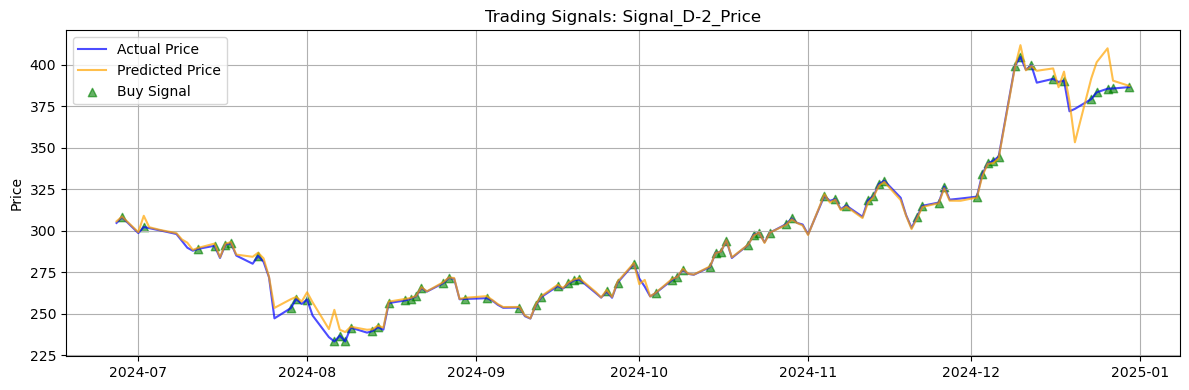

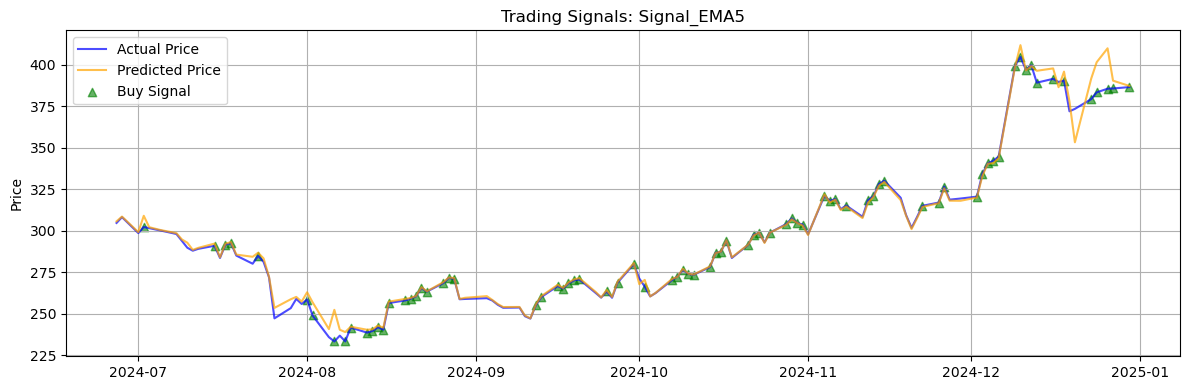

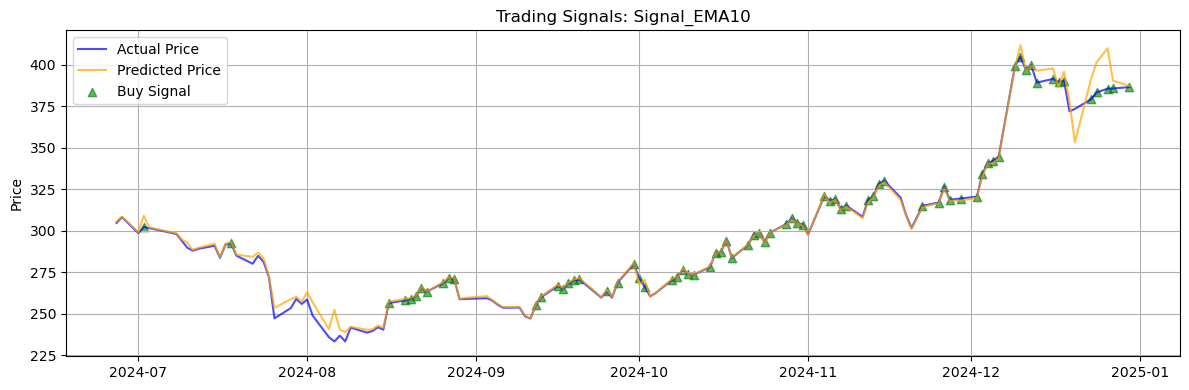

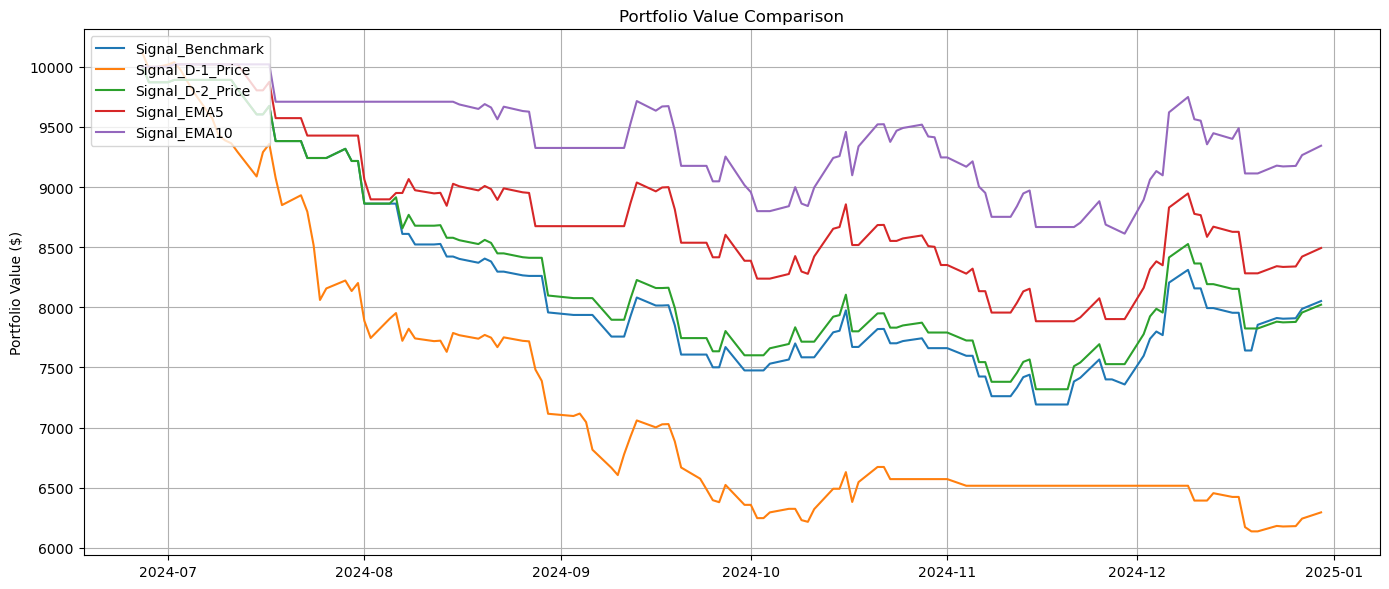

,Final Value,Cumulative Return,Annualized Return,Annualized Volatility,Max Drawdown,Sharpe Ratio,Num Trades,Win Rate
Signal_Benchmark,8052.483014,-0.194752,-0.345010,0.228055,0.280778,-1.697102,75,0.493333
Signal_D-1_Price,6295.425791,-0.370457,-0.595053,0.231767,0.393120,-2.748775,89,0.415730
Signal_D-2_Price,8022.029563,-0.197797,-0.349840,0.226585,0.268086,-1.729429,75,0.506667
Signal_EMA5,8493.602343,-0.150640,-0.273088,0.223156,0.213156,-1.412069,79,0.544304
Signal_EMA10,9343.890006,-0.065611,-0.124157,0.213487,0.140461,-0.778408,74,0.554054


In [6]:
# ===========================================
# Execution
# ===========================================

trade_price = generate_strategy_signals(trade_price)
strategies = ['Signal_Benchmark','Signal_D-1_Price','Signal_D-2_Price','Signal_EMA5','Signal_EMA10']
portfolio_results, trade_counts = compare_strategies(trade_price, strategies, 
                                                     initial_balance=10000, transaction_cost=0.001)
risk_free_rate = trade_price['RF'].mean()
performance = backtest_results(
    trade_price=trade_price,
    portfolio_results=portfolio_results,
    strategies=strategies,
    initial_balance=10000,
    risk_free_rate=risk_free_rate
)
performance